# Exploring CMH Parking Violations

## Imports

* pandas
* string
    * parse string amounts to translate into floats

In [508]:
#%matplotlib inline

import datetime
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import osmnx as ox
import networkx as nx

## Loading data

### Violations

[Columbus City Parking Violations and Ticket Status 2013-2018 -- COLUEXTRACT](https://discovery.smartcolumbusos.com/dataset/conduent/160c98a1_ad56_4658_8553_5ee8e7d0d953) - Smart Columbus

This dataset covers the parking violations identified by Parking Enforcement Officer (PEO) and the tickets issued for those violations. Also, the data identifies the status of the ticket (e.g., paid, dismissed, etc.,) This dataset covers years 2013 through 2018.

In [509]:
violations_full = pd.read_csv("../data/raw/160c98a1-ad56-4658-8553-5ee8e7d0d953.csv.gz", compression = 'gzip', low_memory = False)

### Meters


Meters is a dataset that contains the location of every meter in Columbus.  The Violations
dataset reports the meter where a violation was issued, but the location is often missing, and even when it's there it's location doesn't precisely match that of the meter for which the
violation was issued.  I suspect this is because the location is based on where the the
Agent (or their hand-held device) when the data was transmitted.

Thankfully the meter number is present in the Violations dataset, so we can join the Violations and Meters dataset to get the location of the meter for which a violation was issued.

In [510]:
meters = pd.read_csv("../data/raw/d9b11b8f-67f3-48c4-8831-0f22d93166ce")

In [511]:
pd.set_option('display.max_columns', None)
# uncomment to see all the fields and their types:
#violations_full.info()

### Dictionary for parking violations
An explanation of all the fields in the violations dataset


In [512]:
violations_dictionary = pd.read_json("https://data.smartcolumbusos.com/api/v1/dataset/160c98a1-ad56-4658-8553-5ee8e7d0d953/dictionary")
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', -1)
violations_dictionary.head(98)

,type,name,description
0,integer,ENTITY,Unique system-generated number to identify license plate-based accounts
1,integer,TERMDT,"If a license plate was on a fleet and terminated, this would record the date on which the plate was terminated from the fleet. Julian date format."
2,integer,MULTNO,"If a license plate was on a fleet, that fleet is identified with this number"
3,string,ENT DUE,Total amount due on the entity
4,string,ENT OVP,Overpaid amount on the entity
5,integer,CONF DT,Date on which the BMV/Registry returned registered owner name and address information
6,integer,HOLD CT,Total number of tickets on the entity on registration hold
7,integer,LAST SEIZ,Date on which the vehicle was last seized
8,string,SEIZ STAT,Indicates if the vehicle is currently seized
9,integer,SEIZ DT,Date on which the vehicle was released on the last seizure record


In [513]:
# work with the most promissing columns:
interesting_columns = ['ticket', 'entity', 'meter', 'iss dt', 'multno', 'hold ct', 'due', 'fine', 'make', 'iss time', 'time2', 'ticket', 'badge', 'pay amt', 'pay meth', 'plea', 'open ct', 'lat', 'long']
violations = violations_full[interesting_columns].copy()
# TODO: do I need copy?  I *think* I added it to fix an error with modifying a view into a dataframe..

In [514]:
# extract date-related fields
violations['issue_date'] = violations['iss dt'].map(lambda dtStr: datetime.datetime.strptime(str(dtStr), '%Y%j'))
violations['year'] = violations['issue_date'].map(lambda dt: dt.year)
violations['dayOfWeek'] = violations['issue_date'].map(lambda dt: dt.weekday())
violations['hour'] = violations['iss time'] / 100

In [515]:
# convert 'pay amt' and 'fine' into float datatype
trans_dict ={ord('$'): None, ord('('): None, ord(')'): None, ord(","): None} 
violations['amt_float'] = violations['pay amt'].str.translate(trans_dict).astype(float)
violations['fine_float'] = violations['fine'].str.translate(trans_dict).astype(float)

## About fines

#### Show distribution of fine and pay_amt

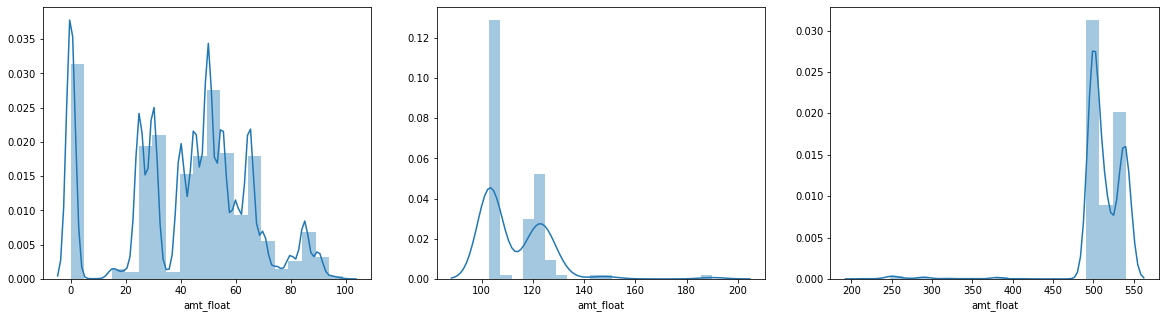

In [516]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, figsize=(20,5))
sns.distplot(violations[violations['amt_float'] < 100]['amt_float'], bins = 20, ax=ax1)
sns.distplot(violations[(violations['amt_float'] > 100) & (violations['amt_float'] <= 200)]['amt_float'], bins = 20, ax=ax2)
sns.distplot(violations[(violations['amt_float'] > 200) & (violations['amt_float'] <= 600)]['amt_float'], bins = 20, ax=ax3)


In [517]:
larger_amt = violations[(violations['amt_float'] >= 600)]
larger_amt

,ticket,entity,meter,iss dt,multno,hold ct,due,fine,make,iss time,time2,ticket,badge,pay amt,pay meth,plea,open ct,lat,long,issue_date,year,dayOfWeek,hour,amt_float,fine_float
640038,5565922485,3542570,NaN,2016099,0,0,$15.00,$55.00,CHEV,1643,0,5565922485,13,"($5,445.00)",2,NaN,1,0,0,2016-04-08,2016,4,16.43,5445.0,55.0


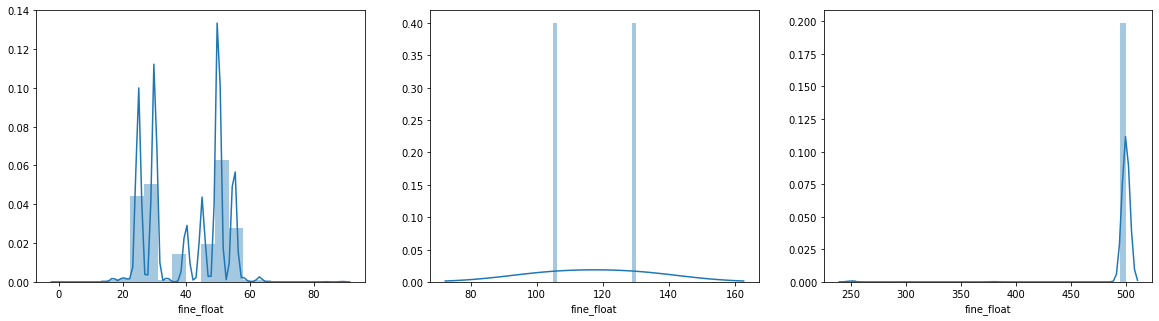

In [518]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, figsize=(20,5))

sns.distplot(violations[violations['fine_float'] < 100]['fine_float'], bins = 20, ax=ax1)
sns.distplot(violations[(violations['fine_float'] >= 100) & (violations['fine_float'] < 200)]['fine_float'], bins = 20, ax=ax2)
sns.distplot(violations[(violations['fine_float'] >= 200) & (violations['fine_float'] < 600)]['fine_float'], ax=ax3)

In [519]:
violations.info()

# note that the data below doesn't show correctly on GitHub, but looks fine in the notebook
violations.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745821 entries, 0 to 745820
Data columns (total 25 columns):
ticket        745821 non-null object
entity        745821 non-null int64
meter         418804 non-null object
iss dt        745821 non-null int64
multno        745821 non-null int64
hold ct       745821 non-null int64
due           745821 non-null object
fine          745821 non-null object
make          744965 non-null object
iss time      745821 non-null int64
time2         745821 non-null int64
ticket        745821 non-null object
badge         733375 non-null object
pay amt       745821 non-null object
pay meth      745821 non-null int64
plea          0 non-null float64
open ct       745821 non-null int64
lat           745821 non-null int64
long          745821 non-null int64
issue_date    745821 non-null datetime64[ns]
year          745821 non-null int64
dayOfWeek     745821 non-null int64
hour          745821 non-null float64
amt_float     745821 non-null float64
fine_fl

,ticket,entity,meter,iss dt,multno,hold ct,due,fine,make,iss time,time2,ticket,badge,pay amt,pay meth,plea,open ct,lat,long,issue_date,year,dayOfWeek,hour,amt_float,fine_float
112850,5564788850,3471588,NaN,2015128,0,0,$0.00,$50.00,FORD,1723,0,5564788850,13,$50.00,4,NaN,0,0,0,2015-05-08,2015,4,17.23,50.0,50.0
331936,5568320055,3594943,NaN,2018086,0,0,$0.00,$50.00,HOND,1407,0,5568320055,14,$50.00,4,NaN,0,39984506,83018807,2018-03-27,2018,1,14.07,50.0,50.0
330770,5567619506,3660074,EE305,2017297,0,0,$0.00,$30.00,FORD,822,0,5567619506,8,$30.00,4,NaN,0,0,0,2017-10-24,2017,1,8.22,30.0,30.0
185279,5561849502,3312454,NaN,2013169,0,0,$0.00,$40.00,LINC,2256,0,5561849502,17,$55.00,4,NaN,0,0,0,2013-06-18,2013,1,22.56,55.0,40.0
315424,5564329812,3449146,NaN,2015024,0,0,$0.00,$39.00,GMC,846,0,5564329812,10,$54.00,4,NaN,0,0,0,2015-01-24,2015,5,8.46,54.0,39.0
460829,5568156292,3675934,K448,2018032,0,0,$85.00,$50.00,MAZD,2131,0,5568156292,18,$0.00,0,NaN,3,39977049,83005040,2018-02-01,2018,3,21.31,0.0,50.0
273522,5566650872,3301248,NaN,2016313,0,0,$0.00,$55.00,CHEV,1708,0,5566650872,20,$55.00,4,NaN,0,0,0,2016-11-08,2016,1,17.08,55.0,55.0
434344,5595415961,3364558,NaN,2014026,0,0,$65.00,$50.00,JEEP,2400,0,5595415961,2434,$0.00,0,NaN,1,0,0,2014-01-26,2014,6,24.00,0.0,50.0
320870,5595045344,3334507,NaN,2013257,0,0,$0.00,$40.00,HOND,330,0,5595045344,1293,$0.00,0,NaN,0,0,0,2013-09-14,2013,5,3.30,0.0,40.0
527832,5596093782,3605935,NaN,2017025,0,0,$0.00,$50.00,CHEV,0,0,5596093782,2398,$50.00,4,NaN,0,0,0,2017-01-25,2017,2,0.00,50.0,50.0


In [520]:
# distribution of outliers - entities who got more than 25 tickets
entity_tickets = violations[['entity', 'amt_float', 'fine_float']].groupby('entity').agg(['count', 'sum']).sort_values([('amt_float', 'count')], ascending=False)
print(entity_tickets.head(25))

        amt_float         fine_float        
            count     sum      count     sum
entity                                      
3306104  171       5965.0  171        4900.0
3172961  149       6110.0  149        4415.0
3118181  141       5990.0  141        4355.0
2954098  107       3530.0  107        3125.0
3177010  100       3315.0  100        2830.0
3310867  96        4427.0  96         2892.0
3190248  93        3515.0  93         2960.0
3369215  88        3775.0  88         2485.0
3373505  83        3625.0  83         2545.0
3577369  82        3195.0  82         2460.0
3044891  82        3095.0  82         2165.0
3474796  81        3060.0  81         2490.0
3307004  81        3815.0  81         2635.0
3020192  79        2845.0  79         2480.0
3341297  77        3405.0  77         2320.0
3244622  77        3305.0  77         2190.0
3132197  75        3230.0  75         2225.0
2857433  74        2675.0  74         2055.0
3223602  73        2755.0  73         2085.0
2900185  7

#### distribution of fines

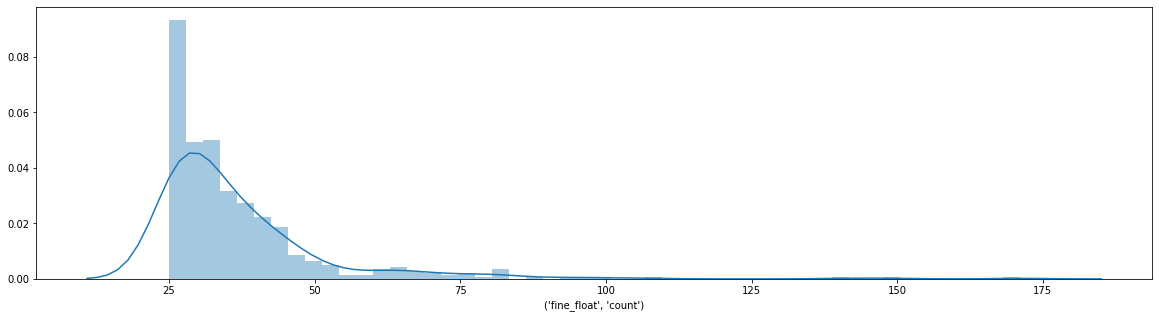

In [521]:
f, ax1 = plt.subplots(1, 1, sharex=False, figsize=(20,5))
sns.distplot(entity_tickets[('fine_float', 'count')]\
             [(entity_tickets[('fine_float', 'count')] >= 25)], bins = 50, ax=ax1)

In [522]:
# wonder why number of violations issued went down the last three years?
violations['year'].value_counts()

2014    158001
2013    157787
2015    141000
2016    137000
2017    119000
2018    33033 
Name: year, dtype: int64

#### Distribution of fines by day of the week

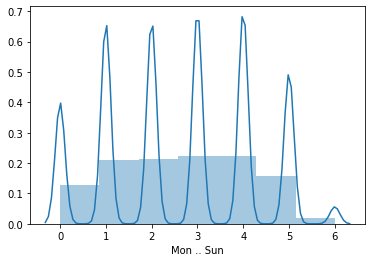

In [523]:
# Monday and Sunday are lighter days for parking tickets
sns.distplot(violations['dayOfWeek'], bins = 7, axlabel="Mon .. Sun")

#### Distribution of fines by time of the day

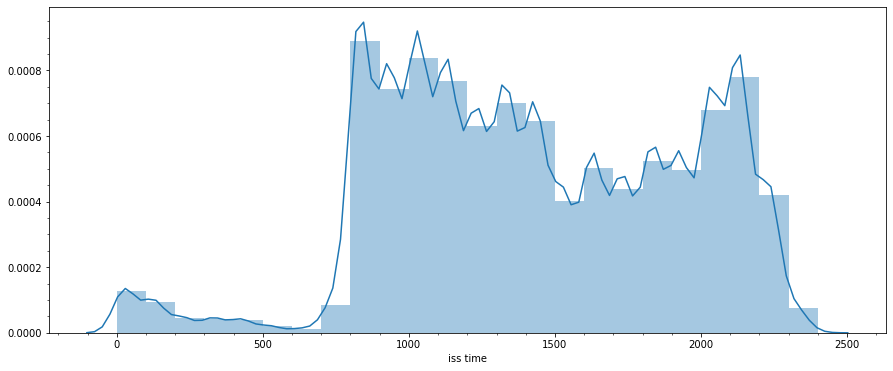

In [524]:
plt.figure(figsize=(15, 6))
ax = sns.distplot(violations['iss time'], bins = 24, norm_hist=True,)
ax.minorticks_on()

#### All about agents (as identified by badge) who gave most tickets

In [525]:
print(violations[['badge']].describe())
agent_business = violations[['badge','year', 'entity', 'ticket', 'fine_float']]\
    .groupby(['badge', 'year'])\
        .agg({'fine_float': ['mean', 'min', 'max'], 'entity': ['count']})

agent_business.columns = ['fine_mean', 'fine_min', 'fine_max', 'entity_count']
agent_business.reset_index().sort_values('entity_count', ascending=False).head(25)

         badge
count   733375
unique  2051  
top     13    
freq    73110 


,badge,year,fine_mean,fine_min,fine_max,entity_count
1848,19,2013,35.593301,17.0,500.0,24003
408,13,2015,42.127513,25.0,500.0,18202
1849,19,2014,34.760192,17.0,500.0,18127
2026,20,2015,43.643559,25.0,500.0,17498
407,13,2014,35.339367,20.0,500.0,16684
409,13,2016,43.338548,22.0,500.0,16683
2027,20,2016,45.177827,22.0,500.0,15695
410,13,2017,44.916014,25.0,500.0,14693
7,10,2014,41.541395,17.0,500.0,13214
6,10,2013,42.017471,17.0,500.0,12936


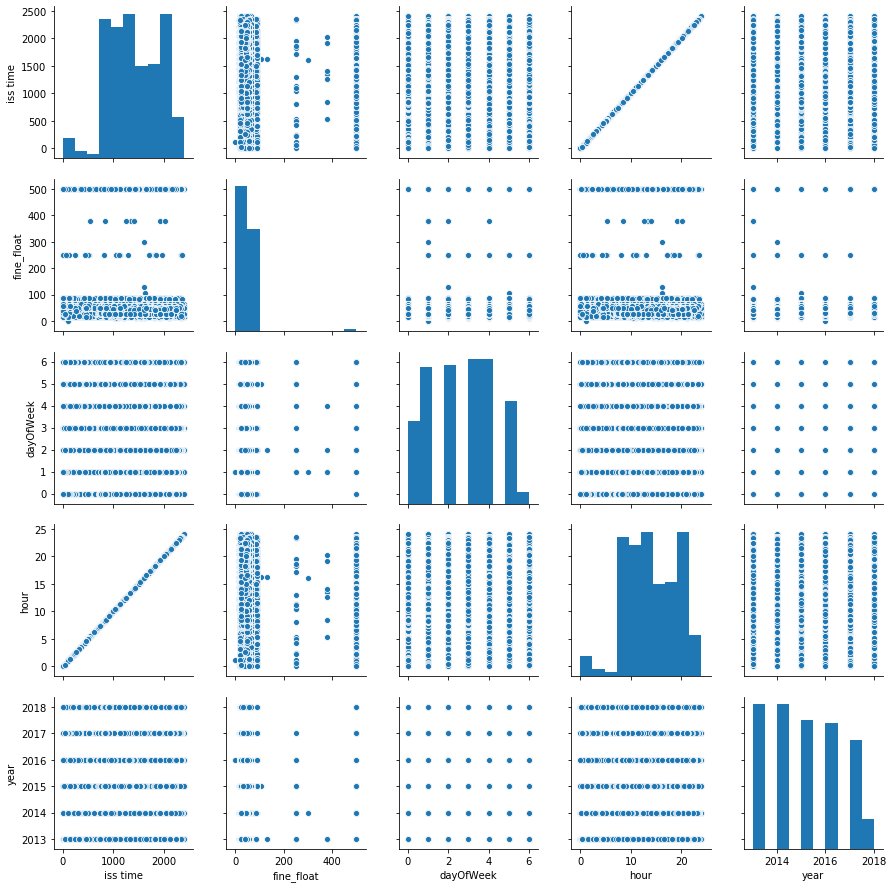

In [526]:
violations_clean = violations[['iss time', 'fine_float', 'dayOfWeek', 'hour', 'year']].dropna()
sns.pairplot(violations_clean)

#### How many tickets are generally given each day?

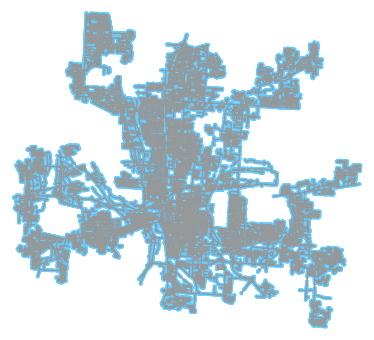

In [527]:
# get network graph for Columbus from disk if available (much faster to load)
try:
    G = ox.load_graphml('cmh_network.graphml')
except IOError:
    print("Download and save network.")
    G = ox.graph_from_place('Columbus, Ohio, USA', network_type='drive', simplify=False)
    ox.save_graphml(G, filename='cmh_network.graphml')
    G = ox.load_graphml('cmh_network.graphml')

fig, ax = ox.plot_graph(G)

In [528]:
# get min, max for lat long as coordinates from G, to get bounds
cmh_gdf = ox.graph_to_gdfs(G)
print(cmh_gdf[0].x.agg(['min', 'max']))
print(cmh_gdf[0].y.agg(['min', 'max']))

cmh_n = float(cmh_gdf[0].y.agg('max'))
cmh_s = float(cmh_gdf[0].y.agg('min'))
cmh_e = float(cmh_gdf[0].x.agg('max'))
cmh_w = float(cmh_gdf[0].x.agg('min'))

print(cmh_n, cmh_s, cmh_e, cmh_w)

min   -83.173106
max   -82.771960
Name: x, dtype: float64
min    39.860829
max    40.139201
Name: y, dtype: float64
40.139201 39.860829 -82.7719601 -83.173106


In [529]:
# convert lat/long to usable lat/long float values
violations['lat_float'] = violations['lat'] / 1000000
violations['long_float'] = violations['long'] / 1000000 * -1

#### Exploring Meters

In [530]:
# meters

meters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5490 entries, 0 to 5489
Data columns (total 8 columns):
Zone            5490 non-null object
Area            5490 non-null object
Sub Area        5490 non-null object
Meter Number    5490 non-null object
ConfigId        5490 non-null int64
Lat             5490 non-null float64
Long            5490 non-null float64
Active          5490 non-null int64
dtypes: float64(2), int64(2), object(4)
memory usage: 343.2+ KB


In [531]:
#meters[meters['meter number'] == 'EN529']

meters = meters.rename(columns = {'Meter Number': 'Meter'})
meters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5490 entries, 0 to 5489
Data columns (total 8 columns):
Zone        5490 non-null object
Area        5490 non-null object
Sub Area    5490 non-null object
Meter       5490 non-null object
ConfigId    5490 non-null int64
Lat         5490 non-null float64
Long        5490 non-null float64
Active      5490 non-null int64
dtypes: float64(2), int64(2), object(4)
memory usage: 343.2+ KB


### Merging violations and meters

In [532]:
violations = violations.rename(columns = { 'meter': 'Meter'})
violations.info()
meters_loc = meters[['Meter', 'Lat', 'Long']]

violations_x_meters = violations.merge(meters, how = 'left', on = 'Meter')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745821 entries, 0 to 745820
Data columns (total 27 columns):
ticket        745821 non-null object
entity        745821 non-null int64
Meter         418804 non-null object
iss dt        745821 non-null int64
multno        745821 non-null int64
hold ct       745821 non-null int64
due           745821 non-null object
fine          745821 non-null object
make          744965 non-null object
iss time      745821 non-null int64
time2         745821 non-null int64
ticket        745821 non-null object
badge         733375 non-null object
pay amt       745821 non-null object
pay meth      745821 non-null int64
plea          0 non-null float64
open ct       745821 non-null int64
lat           745821 non-null int64
long          745821 non-null int64
issue_date    745821 non-null datetime64[ns]
year          745821 non-null int64
dayOfWeek     745821 non-null int64
hour          745821 non-null float64
amt_float     745821 non-null float64
fine_fl

#### Set the violation location from the meters dataset if available

In [533]:
# TODO: make faster if possible.. vectorization?
fudge = 0.2
violations_x_meters['lat_combined'] = \
    violations_x_meters.apply(lambda p: p['Lat'] if (p['Lat'] >  cmh_s - fudge) & (p['Lat'] < cmh_n + fudge) \
                                    else p['lat_float'], axis=1)
violations_x_meters['long_combined'] = \
    violations_x_meters.apply(lambda p: p['Long'] if (p['Long'] >  cmh_w - fudge) & (p['Long'] < cmh_e + fudge)  \
                                    else  p['long_float'], axis=1)
violations_x_meters.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 745821 entries, 0 to 745820
Data columns (total 36 columns):
ticket           745821 non-null object
entity           745821 non-null int64
Meter            418804 non-null object
iss dt           745821 non-null int64
multno           745821 non-null int64
hold ct          745821 non-null int64
due              745821 non-null object
fine             745821 non-null object
make             744965 non-null object
iss time         745821 non-null int64
time2            745821 non-null int64
ticket           745821 non-null object
badge            733375 non-null object
pay amt          745821 non-null object
pay meth         745821 non-null int64
plea             0 non-null float64
open ct          745821 non-null int64
lat              745821 non-null int64
long             745821 non-null int64
issue_date       745821 non-null datetime64[ns]
year             745821 non-null int64
dayOfWeek        745821 non-null int64
hour             

#### Distribution of number of violations given per day in Columbus

            Meter
issue_date       
2013-01-01  0    
2013-01-02  354  
2013-01-03  384  
2013-01-04  379  
2013-01-05  320  
...         ...  
2018-04-17  276  
2018-04-18  275  
2018-04-19  254  
2018-04-20  257  
2018-04-21  30   

[1937 rows x 1 columns]


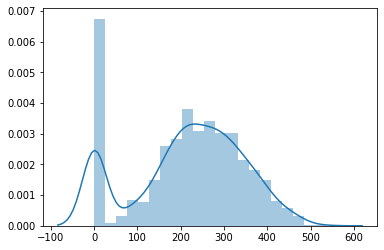

In [534]:
violations_by_day = violations[['issue_date', 'Meter']].groupby(['issue_date']).count()
sns.distplot(violations_by_day)
print(violations_by_day)

In [535]:
# violations_x_meters.head(12)

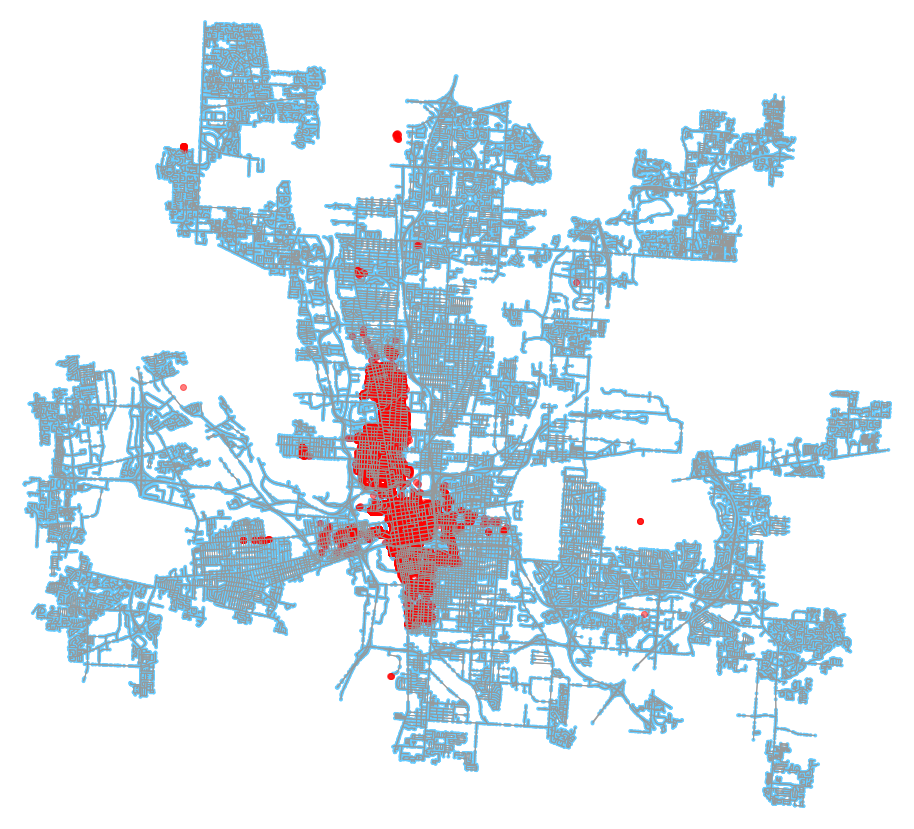

In [536]:
fig, ax = ox.plot_graph(G, fig_height=15, show=False, close=False)
ax.scatter(violations_x_meters['long_combined'], violations_x_meters['lat_combined'], alpha=0.5, c='red')

In [537]:
heat_tickets = violations_x_meters[(violations_x_meters['badge'] == '19') & \
                                   (violations_x_meters['lat_combined'] > 0) & \
                                   (violations_x_meters['long_combined'] < 0) & \
                                   (violations_x_meters['issue_date'] == '2014-02-13')]\
                                   .sort_values(by='iss time')\
                                   [['Meter', 'lat_combined', 'long_combined']].dropna()\
                                    
heat_tickets.shape


(63, 3)

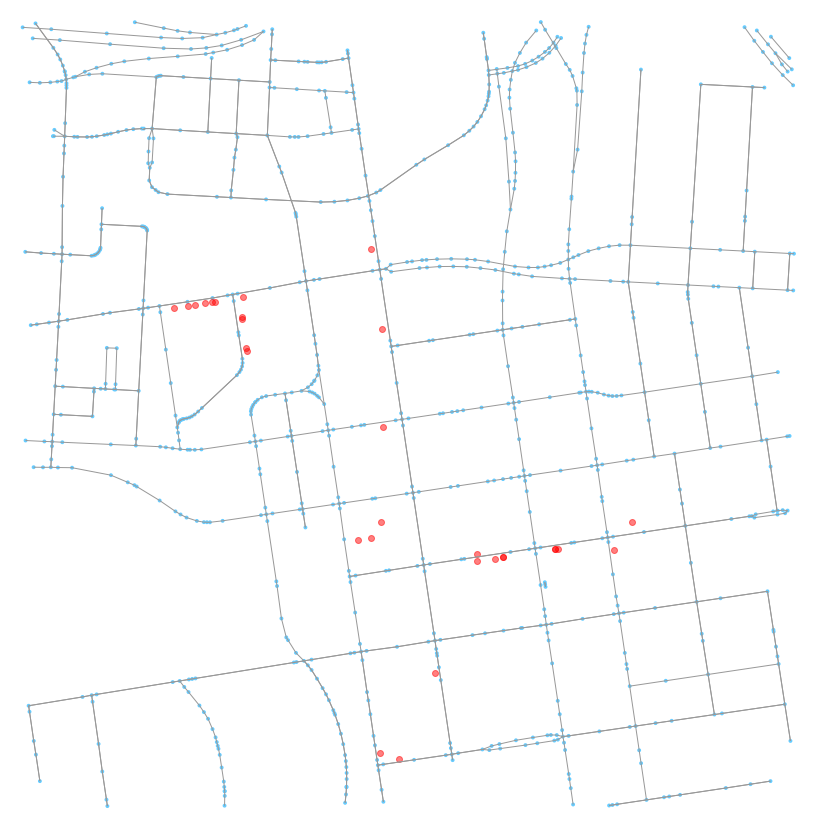

In [538]:
# Would like to create a heat map for just this area
bbox = ox.core.bbox_from_point((39.966358, -83.001397),800)
north, south, east, west = bbox

G_temp_small = ox.graph_from_bbox(north, south, east, west, network_type='drive', simplify=False, retain_all=True)
fig, ax = ox.plot_graph(G_temp_small, fig_height=15, show=False, close=False)
ax.scatter(heat_tickets['long_combined'], heat_tickets['lat_combined'], alpha=0.5, c='red')

In [539]:
# get nearest node to each meter location

def heat_nodes(heat_tickets):
    for ticket in heat_tickets.values:
        meter, lat, long  = ticket
        yield ox.get_nearest_node(G, (lat, long))

In [540]:
# %load ~/Library/Caches/pypoetry/virtualenvs/cmh-packing-violations-JzEtr0-_-py3.7/lib/python3.7/site-packages/heatmapx/__init__.py
__version__ = '0.1.0'
__all__ = ['temperature_graph']

import itertools

from typing import Iterable, Optional, Union

import networkx as nx


def temperature_graph(
    G: nx.Graph,
    source_nodes: Iterable,
    depth_limit: Optional[int] = None,
    heat_increments: Union[Iterable, float] = 1,
    heat_key: str = 'heat'
) -> nx.Graph:
    """
    Calculate temperatures radiating from heat sources in a graph.

    Temperature values are initially set to 0 and then updated throughout `G` in
    a breadth-first manner beginning at each node in `source_nodes`.  For each
    source node `s`, the temperature of each edge `e` and its incident nodes in
    `G` are updated according to `heat_increments` and how many edges away they
    are from the source node `s`.  This process is repeated for every source
    node, with temperatures from multiple source nodes contibuting additively to
    the overall temperature of the nodes and edges in the graph.


    Parameters
    ----------
    G : networkx.Graph
        The graph from which to generate a heatmap.  A copy of the graph will be
        produced by default.

    source_nodes : Iterable
        The nodes serving as heat sources in `G`.

    depth_limit : Optional[int]
        The maximum number of edges away from a source node to update
        temperature values.  (Default: 0)

    heat_increments : Union[Iterable, float]
        A sequence whose `n`-th element gives, for each source node `s`, the
        amount to update the temperature of each node and edge that is `n`
        breadth-first layers away from `s`.  A constant value may also be
        provided to apply to all nodes and edges in the same connected component
        as each source node.  (Default: 1)

    heat_key : str
        The name of the node and edge attribute where temperature values will be
        stored in `T`.

    Returns
    -------
    T : networkx.Graph
        A copy of `G` in which every node and edge has its temperature stored in
        a `heat_key` attribute.
    """
    T = type(G)()
    T.add_nodes_from(G.nodes(), **{heat_key: 0})
    T.add_edges_from(G.edges(), **{heat_key: 0})

    try:
        heat_increments = iter(heat_increments)
    except TypeError:
        heat_increments = itertools.repeat(heat_increments)

    for source in source_nodes:
        visited_nodes = set()
        data_by_depth = itertools.islice(
            zip(_edge_bfs_by_depth(T, [source]), heat_increments),
            depth_limit)
        for edges_at_depth, heat_increment in data_by_depth:
            for edge in edges_at_depth:
                _update_edge_temperature(T, edge, heat_key, heat_increment)
                _update_node_temperatures(T, edge, heat_key, heat_increment,
                                          visited_nodes)
    return T


def _edge_bfs_by_depth(G, source_nodes, orientation=None):
    yield from _group_by_sources(
        nx.edge_bfs(G, source_nodes, orientation),
        set(source_nodes))


def _group_by_sources(edges_iterator, initial_sources):
    edges = iter(edges_iterator)

    current_group_sources = set(initial_sources)
    current_group = []

    for current_edge in edges:
        if current_edge[0] in current_group_sources:
            current_group.append(current_edge)
        else:
            yield current_group
            current_group_sources = {target for _, target, _ in current_group}
            current_group = [current_edge]

    yield current_group


def _update_edge_temperature(G, edge, heat_key, heat_increment):
    G.edges[edge][heat_key] += heat_increment


def _update_node_temperatures(G, nodes, heat_key, heat_increment, visited_nodes):
#     print(G, nodes, heat_key, heat_increment, visited_nodes)
    for node in set(nodes[:2]).difference(visited_nodes):
        G.nodes[node][heat_key] += heat_increment
        visited_nodes.add(node)


In [541]:
bbox = ox.core.bbox_from_point((39.966358, -83.001397),4000)
north, south, east, west = bbox
G_small = ox.graph_from_bbox(north, south, east, west, network_type='drive', simplify=False, retain_all=True)


In [542]:
%time T = temperature_graph(G, heat_nodes(heat_tickets), heat_increments=1, depth_limit=20)

CPU times: user 21.7 s, sys: 643 ms, total: 22.3 s
Wall time: 23 s


In [543]:
import networkx as nx

nx.set_node_attributes(T, {node: data for node, data in G.nodes(data=True)})

In [544]:
nx.set_edge_attributes(
    T, {(source, target, key): data
        for source, target, key, data
        in G.edges(keys=True, data=True)})

In [545]:
T.graph['crs'] = G.graph['crs']
T.graph['name'] = G.graph['name']

In [546]:
heat_node_values = [heat for (id, heat) in list(T.nodes(data='heat'))]
heat_edge_values = [heat for (source, dest, heat) in list(T.edges(data='heat'))]
print (len(heat_node_values), len(heat_edge_values))

107612 213413


In [547]:
heat_to_color = {
 0:"#f8f7f6"   ,
 1:"#fff5ef"   ,
 2:"#fff5ef"   ,
 3:"#ffe7dc"   ,
 4:"#ffe7dc"   ,
 5:"#ffdac8"   ,
 6:"#ffdac8"   ,
 7:"#ffcdb4"   ,
 8:"#ffcdb4"   ,
 9:"#ffc0a1"   ,
 10:"#ffc0a1"  ,
 11:"#ffb38d"  ,
 12:"#ffb38d"  ,
 13:"#ffa67a"  ,
 14:"#ffa67a"  ,
 15:"#ff9966"  ,
 16:"#ff9966"  ,
 17:"#ff8c52"  ,
 18:"#ff8c52"  ,
 19:"#ff7f3f"  ,
 20:"#ff7f3f"  ,
 21:"#ff722b"  ,
 22:"#ff722b"  ,
 23:"#ff6518"  ,
 24:"#ff6518"  ,
 25:"#ff5804"  ,
 26:"#ef5000"  ,
 27:"#dc4900"  ,
 28:"#c84300"  ,
 29:"#b43c00"  ,
 30:"#a13600"  ,
 31:"#8d2f00"  ,
 32:"#7a2900"  ,
 33:"#662200"  }


node_heat_colors = [heat_to_color[heat] for heat in heat_node_values]
edge_heat_colors = [heat_to_color[heat] for heat in heat_edge_values]
print (len(node_heat_colors), len(edge_heat_colors))

107612 213413


In [548]:
#ox.plot.get_edge_colors_by_attr(T, 'heat', num_bins=5)
# this does not work with categorical data.. yet, although they are thinking of 
# adding this feature

(<Figure size 1556.33x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2562e9550>)

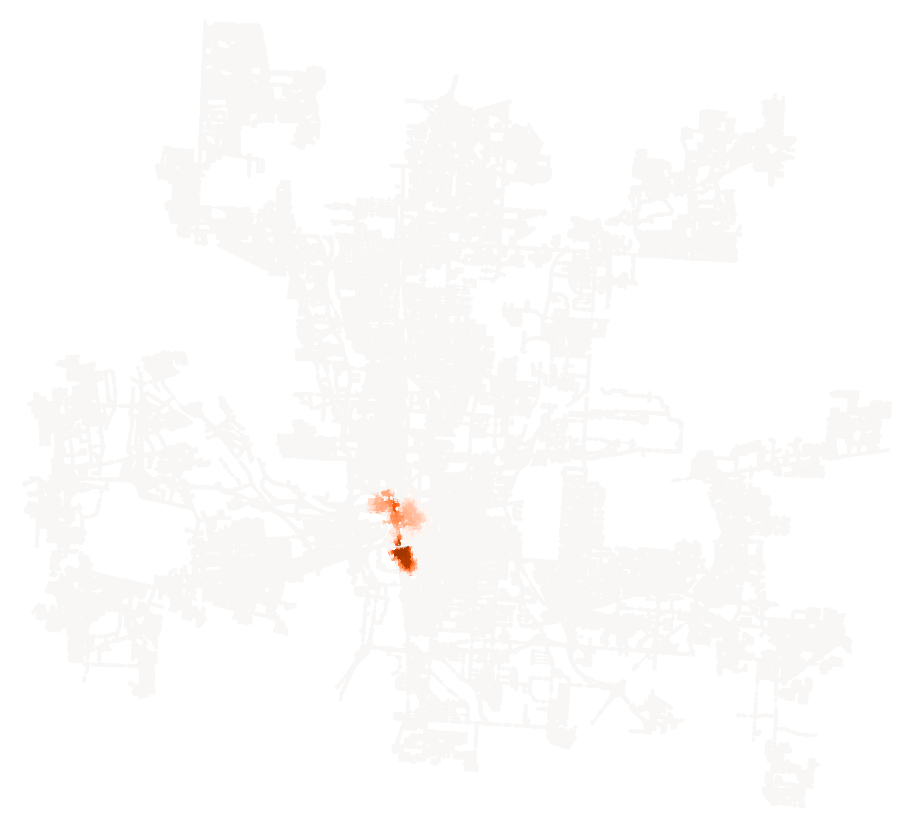

In [549]:
ox.plot_graph(T, fig_height=15, show=False, close=False, node_color = node_heat_colors, edge_color = edge_heat_colors)

### Plot a route from two points on the graph

In [550]:
tickets = heat_tickets
origin_point = (tickets[0:1].lat_combined.iloc[0], tickets[0:1].long_combined.iloc[0])
destination_point = (tickets[61:62].lat_combined.iloc[0], tickets[61:62].long_combined.iloc[0])

In [551]:
origin_node = ox.get_nearest_node(G, origin_point)
destination_node = ox.get_nearest_node(G, destination_point)
origin_node, destination_node

(230027153, 5363977927)

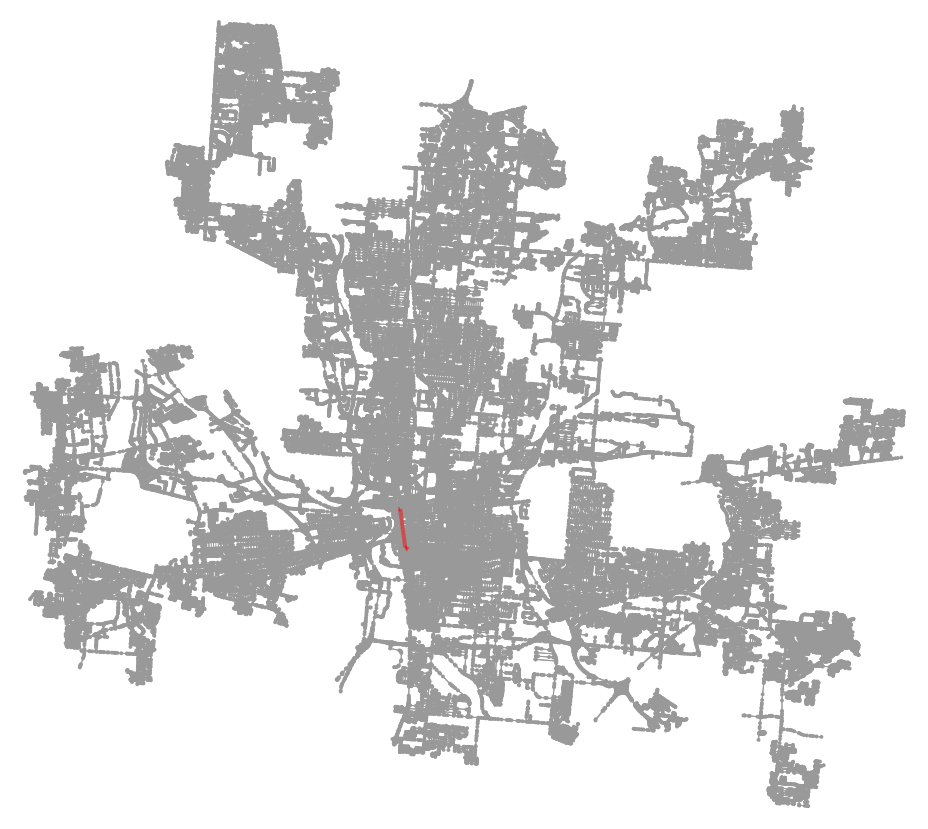

In [552]:
route = nx.shortest_path(G, origin_node, destination_node, weight='length')

bbox = ox.core.bbox_from_point((39.966358, -83.001397),800)
north, south, east, west = bbox

G_temp_small = ox.graph_from_bbox(north, south, east, west, network_type='drive', simplify=False, retain_all=True)

# when plotting a route from a bounded box it fails.. something gets extracted, but it works with full map
projected = ox.project_graph(G)
fig, ax = ox.plot_graph_route(projected, route, origin_point=origin_point, 
                             destination_point=destination_point, fig_height=15, show=False, close=False)


### Color-code tickets by issuing Agent

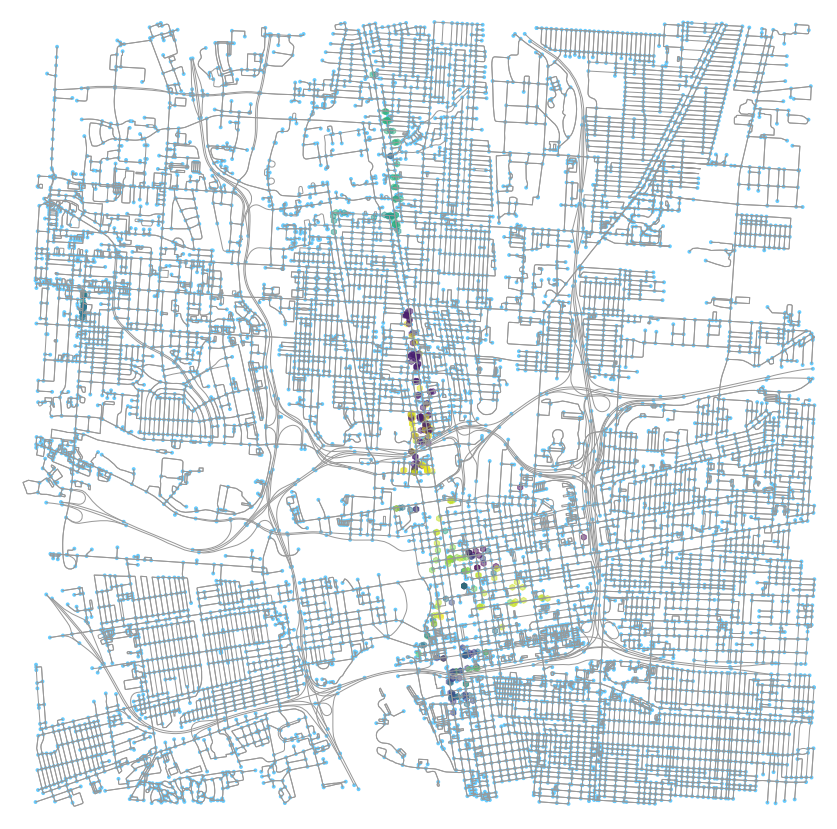

In [553]:
# 2013-01-03
violations_for_day = violations_x_meters[violations_x_meters['issue_date'] == '2013-01-03']

bbox = ox.core.bbox_from_point((39.977110, -83.003500), 4000)
north, south, east, west = bbox
G0 = ox.graph_from_bbox(north, south, east, west, network_type='drive_service')
fig, ax = ox.plot_graph(G0, fig_height=15, show=False, close=False)

import hashlib
def encode_badge(badge):
    encoded_badge = str(badge).encode('utf-8')
    return int(hashlib.sha1(encoded_badge).hexdigest(), 16) % (10 ** 8) % 10000
 
badge_to_colors = violations_for_day['badge'].map(encode_badge)                                    
ax.scatter(violations_for_day['long_combined'], violations_for_day['lat_combined'], \
           alpha=0.5, c=badge_to_colors, marker = 'h')

In [554]:
bbox = ox.core.bbox_from_point((39.977110, -83.003500), 500)
north, south, east, west = bbox
short_north_violations = violations_x_meters[(violations_x_meters['long_combined'] < east) &
                                            (violations_x_meters['long_combined'] > west) &
                                            (violations_x_meters['lat_combined'] < north) &
                                            (violations_x_meters['lat_combined'] > south) &
                                            (violations_x_meters['year'] == 2017)
                                            ]
short_north_violations.shape
G1 = ox.graph_from_bbox(north, south, east, west, network_type='drive_service')

In [555]:
short_north_violations.shape

(11924, 36)

In [556]:
early_morning_violations =  short_north_violations[(short_north_violations['iss time'] >= 500) & \
                                                     (short_north_violations['iss time'] < 700)]
morning_violations = short_north_violations[(short_north_violations['iss time'] >= 700) & \
                                                     (short_north_violations['iss time'] < 1000)]
midday_violations =  short_north_violations[(short_north_violations['iss time'] >= 1000) & \
                                                     (short_north_violations['iss time'] < 1400)]
afternoon_violations = short_north_violations[(short_north_violations['iss time'] >= 1400) & \
                                                     (short_north_violations['iss time'] < 1800)]
evening_violations =  short_north_violations[(short_north_violations['iss time'] >= 1800) & \
                                                     (short_north_violations['iss time'] < 2200)]
night_violations =  short_north_violations[(short_north_violations['iss time'] >= 2300) & \
                                                     (short_north_violations['iss time'] < 500)]

#### Create bounding box 1 mile around the Forge, and plot violations around this area

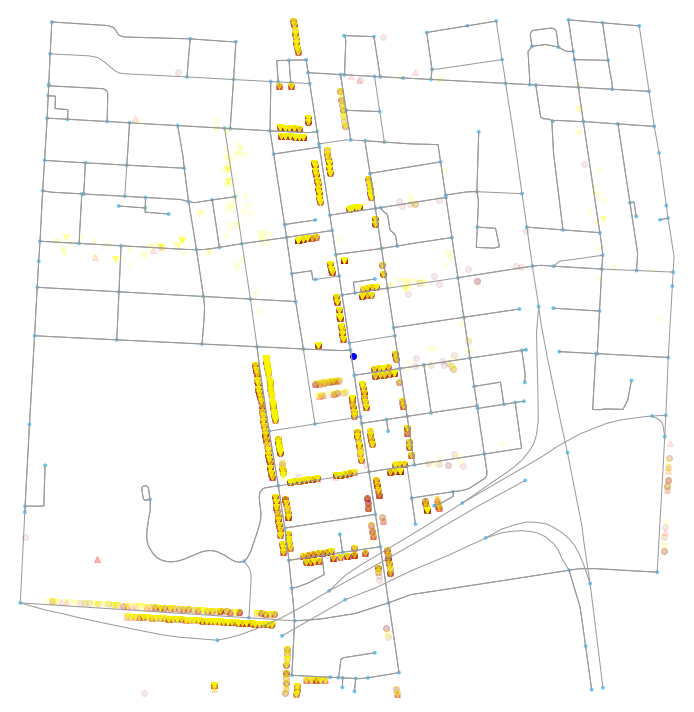

In [557]:
fig, ax = ox.plot_graph(G1, fig_height=10,show=False, close=False)
#ax.scatter(violations_x_meters['long_combined'], violations_x_meters['lat_combined'], alpha=0.2, c='red')

#ax.scatter(midday_violations['long_combined'], midday_violations['lat_combined'], alpha=0.1, c='green', marker="o")
ax.scatter(morning_violations['long_combined'], morning_violations['lat_combined'], alpha=0.1, c='red',marker="^")
ax.scatter(afternoon_violations['long_combined'], afternoon_violations['lat_combined'], alpha=0.1, c='brown')
ax.scatter(evening_violations['long_combined'], evening_violations['lat_combined'], alpha=0.1, c='yellow',marker="v")
#ax.scatter(night_violations['long_combined'], night_violations['lat_combined'], alpha=0.4, c='gray')

ax.scatter([-83.003500], [39.977110], c='blue')
plt.tight_layout()


### Hot meters -- meters that got most expensive tickets

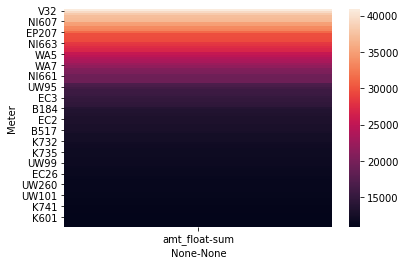

In [558]:
grp = violations_x_meters[['Meter', 'amt_float']].dropna()\
    .groupby(['Meter'], as_index=False)\
    .agg(['sum'])\
    .sort_values([('amt_float', 'sum')], ascending=False)\
    .head(100)
sns.heatmap(grp)


In [559]:
hot_meter_numbers = pd.Series(grp.index)
hot_meters = short_north_violations[violations_x_meters['Meter'].isin(hot_meter_numbers)]

/Users/ovidiu.sofariu/Library/Caches/pypoetry/virtualenvs/cmh-packing-violations-JzEtr0-_-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [560]:
# plot the route with folium
route_map = ox.plot_graph_folium(G1, popup_attribute='name', edge_width=2)

import folium
folium.Marker(
    location=[39.977110, -83.003500],
    popup='The Forge',
    icon=folium.Icon(icon='glyphicon-scale', prefix='glyphicon')
).add_to(route_map)

hot_meters.apply(lambda row: \
              folium.Marker(
                location=[row['lat_combined'], row['long_combined']],
                popup=grp.loc[row['Meter']][('amt_float', 'sum')],
                icon=folium.Icon(icon='scale', color='darkgreen')
             ).add_to(route_map),
             axis=1)

# save to disk
filepath = 'data/graph.html'
route_map.save(filepath)

In [561]:
from IPython.display import IFrame
IFrame(filepath, width=600, height=700)